# ***Short statement explaining the functionality of this code and why this code is important:***
Based on deep learning (DL) concepts, this code has developed an innovative approach that produces general and boosted models capable of more accurately estimating ROPs compared to other techniques. A vital component of this approach is using a deep Artificial Neural Network (ANN) structure known as the Generative Adversarial Network (GAN). The GAN structure is combined with regressor (predictive) ANNs, to boost their performance when estimating the target parameter. An additional innovation of this code is using the residual structure during 1D-CNN network training, which improved the performance of the 1D-CNN by combining the input data with those features extracted from the inputs. (for details, refer to “Developing GAN-boosted Artificial Neural Networks to Model the Rate of Drilling Bit Penetration”. Applied Soft Computing, 2023. (https://doi.org/10.1016/j.asoc.2023.110067))

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import (concatenate, Conv1D,Conv2D,Conv1D,MaxPool2D,add,Input,Dense,Flatten,Reshape,
                                     BatchNormalization,Activation, Layer)
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import (RMSprop,Adam,Nadam)
from tensorflow.keras.activations import relu
from keras.layers import LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping as ES
from tensorflow.keras.regularizers import l2
from keras.models import save_model
import matplotlib
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from scipy.io import savemat
from scipy.io import loadmat

In [ ]:
def R2 (true,predicted):
    import numpy as np
    R2 = np.mean((predicted-predicted.mean())*(true-true.mean()))/(np.std(predicted)*np.std(true))
    return R2
def R(true,predicted):
    R = (np.sum((true-true.mean())*(predicted-predicted.mean())))/(np.sqrt((np.sum((true-true.mean())**2))*np.sum((true-true.mean())**2)))
    return R

In [ ]:
class Bingham(Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(Bingham, self).__init__(**kwargs)
    def build(self, input_shape):
        self.kernel = self.add_weight(name = 'kernel',
          shape = (input_shape[1], self.output_dim),
          initializer = 'normal', trainable = True)
        super(Bingham, self).build(input_shape)
    def call(self, input_data):
        input_data = tf.transpose(input_data)
        rop = input_data[1] * self.kernel[0] * (input_data[0]/8.75)**self.kernel[1]
        return tf.reshape(rop, [tf.shape(rop)[0],1])
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

In [ ]:
df_14 = pd.read_excel('D:\\Hassan\\Work\\my project\\paper\\rop prediction\\thesis paper\\data\\F14-cleaned.xlsx').drop(['MW (g/cc)',
                                                                                                                        'NPHI (DEC)',
                                                                                                                        'RHOB (g/cc)'],axis=1)
df_14

,Depth,ROP (m/hr),RPM,WOB (klb),TORQUE (klb.ft),CGR (GAPI),DT (micSec/ft)
0,2722.0,-0.066181,0.390686,0.821587,-0.810115,-0.529477,-0.810273
1,2722.1,-0.070161,0.390686,0.822381,-0.804747,-0.516730,-0.808406
2,2722.2,-0.074141,0.390686,0.823176,-0.799378,-0.503984,-0.806539
3,2722.3,-0.078120,0.390686,0.823970,-0.794010,-0.491237,-0.804672
4,2722.4,-0.082100,0.390686,0.824764,-0.788642,-0.478490,-0.802804
...,...,...,...,...,...,...,...
6546,3376.6,-2.232378,-0.327316,-0.194696,-2.290383,2.169334,0.037337
6547,3376.7,-2.237606,-0.327316,-0.218333,-2.304889,2.199876,0.062543
6548,3376.8,-2.242834,-0.327316,-0.241970,-2.319396,2.230418,0.087749
6549,3376.9,-2.248062,-0.327316,-0.265607,-2.333902,2.260959,0.112956


In [ ]:
df_15 = pd.read_excel('D:\\Hassan\\Work\\my project\\paper\\rop prediction\\thesis paper\\data\\F15-cleaned.xlsx').drop(['MW (g/cc)',
                                                                                                                        'NPHI (DEC)',
                                                                                                                        'RHOB (g/cc)'],axis=1)
df_15

In [ ]:
data_14 = df_14.values[:,1:]
data_15 = df_15.values[:,1:]
data = np.r_[data_14,data_15]
df_data = pd.DataFrame(data,columns = df_14.columns[1:])
df_data

In [ ]:
x = data[:,1:]
y = data[:,0]

In [ ]:
xtr,xts,ytr,yts = tts(x,y,train_size=0.8,random_state=1,shuffle=True)

print('xtr shape:',xtr.shape)
print('xts shape:',xts.shape)
print('ytr shape:',ytr.shape)
print('yts shape:',yts.shape)

# GAN Model

In [ ]:
def build_gen(shape,zdim):
    model = Sequential()
    model.add(Dense(128,input_dim=zdim))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(20))
    model.add(LeakyReLU(alpha=0.01))
    shp = 1
    for i in shape:
        shp *= i
    model.add(Dense(shp))
    model.add(Reshape(shape))
    return model

def build_dis(shape):
    model=Sequential()
    model.add(Flatten(input_shape=shape))
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(1,activation='sigmoid'))
    return model

def build_gan(gen,dis):
    model = Sequential()
    model.add(gen)
    model.add(dis)
    return model

In [ ]:
shape = (1,1)
dis = build_dis(shape)
dis.compile(loss='binary_crossentropy',
           optimizer=Adam(0.002),
           metrics=['accuracy'])

In [ ]:
dis.trainable = False
zdim = 100 # in our problem, zdim is the number of nodes in last hidden layer of NN model
gen = build_gen(shape,zdim)

In [ ]:
gen.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 128)               12928     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 20)                2580      
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 20)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 21        
_________________________________________________________________
reshape_3 (Reshape)          (None, 1, 1)              0         
Total params: 15,529
Trainable params: 15,529
Non-trainable params: 0
_________________________________________________

In [ ]:
gan = build_gan(gen,dis)
gan.compile(loss='binary_crossentropy',
           optimizer=Adam(learning_rate=0.002))

100 [D loss: 0.718184 , acc: 42.97] [G loss: 0.563694]
200 [D loss: 0.671877 , acc: 67.19] [G loss: 0.695565]
300 [D loss: 0.663615 , acc: 57.81] [G loss: 0.779252]
400 [D loss: 0.670822 , acc: 64.06] [G loss: 0.713420]
500 [D loss: 0.696488 , acc: 46.88] [G loss: 0.709044]
600 [D loss: 0.662326 , acc: 53.91] [G loss: 0.689445]
700 [D loss: 0.698448 , acc: 46.09] [G loss: 0.729529]
800 [D loss: 0.654596 , acc: 52.34] [G loss: 0.742171]
900 [D loss: 0.701960 , acc: 51.56] [G loss: 0.779008]
1000 [D loss: 0.684474 , acc: 60.16] [G loss: 0.744155]
1100 [D loss: 0.722610 , acc: 35.94] [G loss: 0.618342]
1200 [D loss: 0.685700 , acc: 57.03] [G loss: 0.674723]
1300 [D loss: 0.679195 , acc: 53.12] [G loss: 0.666606]
1400 [D loss: 0.684076 , acc: 52.34] [G loss: 0.709805]
1500 [D loss: 0.686805 , acc: 51.56] [G loss: 0.709790]
1600 [D loss: 0.663356 , acc: 49.22] [G loss: 0.807630]
1700 [D loss: 0.662355 , acc: 57.81] [G loss: 0.685601]
1800 [D loss: 0.678242 , acc: 52.34] [G loss: 0.718690]
1

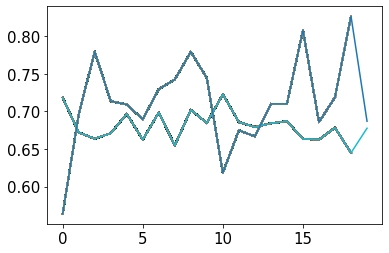

In [ ]:
# training
def train_gan(iterations,batch_size,interval):
    global ytr
    global zdim
    losses = []
    accuracies = []
    iteration_checks = []

    real = np.ones((batch_size,1))
    fake = np.zeros((batch_size,1))

    for iteration in range(iterations):
        ids = np.random.randint(0,ytr.shape[0],batch_size)
        tru = ytr[ids]
        #tru = tru.reshape(tru.shape[0],1)

        z = np.random.normal(0,1,(batch_size,zdim))
        pred = gen.predict(z)

        dis_loss_accuracy_real = dis.train_on_batch(tru,real)
        dis_loss_accuracy_fake = dis.train_on_batch(pred,fake)

        dloss,daccuracy = 0.5 * np.add(dis_loss_accuracy_real,dis_loss_accuracy_fake)

        z = np.random.normal(0, 1, (batch_size, zdim))
        gan_loss = gan.train_on_batch(z,real)

        if (iteration+1) % interval == 0:
            losses.append((dloss,gan_loss))
            accuracies.append(100.0*daccuracy)
            iteration_checks.append(iteration+1)

            print("%d [D loss: %f , acc: %.2f] [G loss: %f]" %
                  (iteration+1,dloss,100.0*daccuracy,gan_loss))
        plt.plot(losses)
        #if daccuracy*100 >= 85:
            #break
train_gan(2000,64,100)

# GAN-ANN Models

In [ ]:
# 1: GAN-Boosted MLP
inputs = Input(shape= xtr.shape[1])
############################
dns = Dense(units = zdim, activation = LeakyReLU(alpha = 0.01))(inputs)
###########################coupling with pretrained generator
MODEL = Model(inputs,dns)
model = Sequential()
model.add(MODEL)
gen.trainable = False
model.add(gen)

In [ ]:
xtr = xtr.reshape(xtr.shape +(1,))
xtr.shape

(10681, 5, 1)

In [ ]:
# 2: GAN-Boosted 1D-CNN
inputs = Input(shape= xtr.shape[1:])
#########################
c1 = Conv1D(32,2,padding='same', activation = LeakyReLU(alpha=0.01))(inputs)
c2 = Conv1D(8,4,padding='same', activation = LeakyReLU(alpha=0.01))(c1)
c3 = Conv1D(32,2,padding='same', activation = LeakyReLU(alpha=0.01))(c2)
########################
fltn = Flatten()(c3)
dns = Dense(zdim, activation= LeakyReLU(alpha=0.01))(fltn)
#######################coupling with pretrained generator
MODEL = Model(inputs,dns)
model = Sequential()
model.add(MODEL)
gen.trainable = False
model.add(gen)

In [ ]:
# 3:GAN-Boosted 1D-Res-CNN
inputs = Input(shape= xtr.shape[1:])
#########################
c1 = Conv1D(32,2,padding='same', activation = LeakyReLU(alpha=0.01))(inputs)
c2 = Conv1D(8,4,padding='same', activation = LeakyReLU(alpha=0.01))(c1)
c3 = Conv1D(32,2,padding='same', activation = LeakyReLU(alpha=0.01))(c2)
########################
conc = concatenate([c3,inputs])
fltn = Flatten()(conc)
dns = Dense(zdim, activation = LeakyReLU(alpha=0.01))(fltn)
#######################coupling with pretrained generator
MODEL = Model(inputs,dns)
model = Sequential()
model.add(MODEL)
gen.trainable = False
model.add(gen)

# Models without Boosting

In [ ]:
# 1: MLP
inputs = Input(shape= xtr.shape[1])
############################
dns = Dense(units = zdim, activation = LeakyReLU(alpha = 0.01))(inputs)
out = Dense(1)(dns)
###########################coupling with pretrained generator
model = Model(inputs,out)

In [ ]:
xtr = xtr.reshape(xtr.shape +(1,))
xtr.shape

(10681, 5, 1)

In [ ]:
# 2:1D-CNN
inputs = Input(shape= xtr.shape[1:])
#########################
c1 = Conv1D(32,2,padding='same', activation = LeakyReLU(alpha=0.01))(inputs)
c2 = Conv1D(8,4,padding='same', activation = LeakyReLU(alpha=0.01))(c1)
c3 = Conv1D(32,2,padding='same', activation = LeakyReLU(alpha=0.01))(c2)
########################
fltn = Flatten()(c3)
dns = Dense(zdim, activation= LeakyReLU(alpha=0.01))(fltn)
out = Dense(1)(dns)
#######################coupling with pretrained generator
model = Model(inputs,out)

In [ ]:
# 1D-Res-CNN
inputs = Input(shape= xtr.shape[1:])
#########################
c1 = Conv1D(16,2,padding='same', activation = LeakyReLU(alpha=0.01))(inputs)
c2 = Conv1D(8,4,padding='same', activation = LeakyReLU(alpha=0.01))(c1)
c3 = Conv1D(16,2,padding='same', activation = LeakyReLU(alpha=0.01))(c2)
########################
conc = concatenate([c3,inputs])
fltn = Flatten()(conc)
dns = Dense(zdim, activation = LeakyReLU(alpha=0.01))(fltn)
out = Dense(1)(dns)
#######################coupling with pretrained generator
model = Model(inputs,out)

## Bingham Model

In [ ]:
Bing_df_14 = pd.read_excel('D:\\Hassan\\Work\\my project\\paper\\rop prediction\\thesis paper\\data\\for bingham\\F14-cleaned_divMax.xlsx')
Bing_df_15 = pd.read_excel('D:\\Hassan\\Work\\my project\\paper\\rop prediction\\thesis paper\\data\\for bingham\\F15-cleaned_divMax.xlsx')
Bing_data_14 = Bing_df_14.values[:,1:]
Bing_data_15 = Bing_df_15.values[:,1:]
Bing_data = np.r_[Bing_data_14,Bing_data_15]
Bing_df_data = pd.DataFrame(Bing_data,columns = Bing_df_14.columns[1:])
Bing_x = Bing_data[:,1:]
Bing_y = Bing_data[:,0]
Bing_xtr,Bing_xts,Bing_ytr,Bing_yts = tts(Bing_x,Bing_y,train_size=0.8,random_state=1,shuffle=True)
print('xtr shape:',Bing_xtr.shape)
print('xts shape:',Bing_xts.shape)
print('ytr shape:',Bing_ytr.shape)
print('yts shape:',Bing_yts.shape)

xtr shape: (10681, 5)
xts shape: (2671, 5)
ytr shape: (10681,)
yts shape: (2671,)


In [ ]:
Bing_df_data

,ROP (m/hr),WOB (klb),TORQUE (klb.ft),MW (g/cc),CGR (GAPI),DT (micSec/ft)
0,0.542075,0.794951,0.723638,0.963235,0.218241,0.760458
1,0.541204,0.795104,0.724212,0.963235,0.219611,0.760608
2,0.540334,0.795257,0.724786,0.963235,0.220981,0.760757
3,0.539463,0.795411,0.725360,0.963235,0.222352,0.760907
4,0.538592,0.795564,0.725934,0.963235,0.223722,0.761056
...,...,...,...,...,...,...
13347,0.085179,0.999456,0.662618,0.946250,0.674785,-0.002963
13348,0.084830,0.999592,0.663472,0.946542,0.674376,-0.003779
13349,0.084482,0.999728,0.664326,0.946834,0.673966,-0.004596
13350,0.084133,0.999864,0.665180,0.947125,0.673557,-0.005412


In [ ]:
Bing_xtr = Bing_xtr[:,[0,1]]
Bing_xts = Bing_xts[:,[0,1]]
bing_input_shape = Bing_xtr.shape[1]

In [ ]:
inputs = Input(shape = bing_input_shape)
bingham_layer = Bingham(1)(inputs)
bing_model = Model(inputs, bingham_layer)

In [ ]:
bing_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 bingham (Bingham)           (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [ ]:
bing_model.compile(loss='mean_squared_error',optimizer=Adam(learning_rate=0.001),metrics=['mse','mae'])

In [ ]:
hist_bing = bing_model.fit(Bing_xtr,Bing_ytr,
                 epochs=2000,validation_split=0.3,verbose=1,
                 callbacks = [ES(monitor='val_loss', patience=50,
                                 restore_best_weights=True)])

Epoch 1/2000
234/234 [==============================] - 1s 3ms/step - loss: 0.2069 - mse: 0.2069 - mae: 0.3874 - val_loss: 0.0773 - val_mse: 0.0773 - val_mae: 0.2191
Epoch 2/2000
234/234 [==============================] - 0s 2ms/step - loss: 0.0366 - mse: 0.0366 - mae: 0.1512 - val_loss: 0.0298 - val_mse: 0.0298 - val_mae: 0.1400
Epoch 3/2000
234/234 [==============================] - 0s 2ms/step - loss: 0.0302 - mse: 0.0302 - mae: 0.1399 - val_loss: 0.0297 - val_mse: 0.0297 - val_mae: 0.1398
Epoch 4/2000
234/234 [==============================] - 0s 1ms/step - loss: 0.0301 - mse: 0.0301 - mae: 0.1396 - val_loss: 0.0296 - val_mse: 0.0296 - val_mae: 0.1394
Epoch 5/2000
234/234 [==============================] - 0s 2ms/step - loss: 0.0299 - mse: 0.0299 - mae: 0.1392 - val_loss: 0.0294 - val_mse: 0.0294 - val_mae: 0.1389
Epoch 6/2000
234/234 [==============================] - 1s 2ms/step - loss: 0.0298 - mse: 0.0298 - mae: 0.1387 - val_loss: 0.0292 - val_mse: 0.0292 - val_mae: 0.1384
Epoc

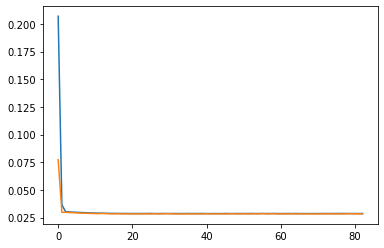

In [ ]:
plt.plot(hist_bing.history['loss'])
plt.plot(hist_bing.history['val_loss'])

# Model Summary and Training

In [ ]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_7 (Functional)    (None, 100)               600       
_________________________________________________________________
sequential_11 (Sequential)   (None, 1, 1)              15529     
Total params: 16,129
Trainable params: 600
Non-trainable params: 15,529
_________________________________________________________________


In [ ]:
lr = 0.02
model.compile(loss='mean_squared_error',optimizer=Adam(learning_rate=lr),metrics=['mse','mae'])

In [ ]:
hist = model.fit(xtr,ytr,
                 epochs=2000,validation_split=0.5,verbose=1,
                 callbacks = [ES(monitor='val_loss', patience=20,
                                 restore_best_weights=True)])

Epoch 1/2000
167/167 [==============================] - 1s 5ms/step - loss: 0.1783 - mse: 0.1783 - mae: 0.3264 - val_loss: 0.1057 - val_mse: 0.1057 - val_mae: 0.2541
Epoch 2/2000
167/167 [==============================] - 0s 3ms/step - loss: 0.1001 - mse: 0.1001 - mae: 0.2495 - val_loss: 0.0887 - val_mse: 0.0887 - val_mae: 0.2315
Epoch 3/2000
167/167 [==============================] - 0s 3ms/step - loss: 0.0881 - mse: 0.0881 - mae: 0.2319 - val_loss: 0.0830 - val_mse: 0.0830 - val_mae: 0.2245
Epoch 4/2000
167/167 [==============================] - 0s 3ms/step - loss: 0.0827 - mse: 0.0827 - mae: 0.2237 - val_loss: 0.0793 - val_mse: 0.0793 - val_mae: 0.2189
Epoch 5/2000
167/167 [==============================] - 0s 3ms/step - loss: 0.0789 - mse: 0.0789 - mae: 0.2177 - val_loss: 0.0731 - val_mse: 0.0731 - val_mae: 0.2100
Epoch 6/2000
167/167 [==============================] - 0s 3ms/step - loss: 0.0768 - mse: 0.0768 - mae: 0.2151 - val_loss: 0.0713 - val_mse: 0.0713 - val_mae: 0.2071
Epoc

167/167 [==============================] - 0s 3ms/step - loss: 0.0227 - mse: 0.0227 - mae: 0.1119 - val_loss: 0.0244 - val_mse: 0.0244 - val_mae: 0.1160
Epoch 100/2000
167/167 [==============================] - 0s 2ms/step - loss: 0.0224 - mse: 0.0224 - mae: 0.1110 - val_loss: 0.0251 - val_mse: 0.0251 - val_mae: 0.1182
Epoch 101/2000
167/167 [==============================] - 0s 2ms/step - loss: 0.0220 - mse: 0.0220 - mae: 0.1093 - val_loss: 0.0240 - val_mse: 0.0240 - val_mae: 0.1143
Epoch 102/2000
167/167 [==============================] - 0s 2ms/step - loss: 0.0226 - mse: 0.0226 - mae: 0.1110 - val_loss: 0.0254 - val_mse: 0.0254 - val_mae: 0.1186
Epoch 103/2000
167/167 [==============================] - 0s 2ms/step - loss: 0.0226 - mse: 0.0226 - mae: 0.1115 - val_loss: 0.0265 - val_mse: 0.0265 - val_mae: 0.1212
Epoch 104/2000
167/167 [==============================] - 0s 2ms/step - loss: 0.0222 - mse: 0.0222 - mae: 0.1105 - val_loss: 0.0272 - val_mse: 0.0272 - val_mae: 0.1242
Epoch 1

Epoch 148/2000
167/167 [==============================] - 0s 3ms/step - loss: 0.0189 - mse: 0.0189 - mae: 0.1017 - val_loss: 0.0203 - val_mse: 0.0203 - val_mae: 0.1038
Epoch 149/2000
167/167 [==============================] - 0s 3ms/step - loss: 0.0190 - mse: 0.0190 - mae: 0.1017 - val_loss: 0.0216 - val_mse: 0.0216 - val_mae: 0.1052
Epoch 150/2000
167/167 [==============================] - 0s 3ms/step - loss: 0.0188 - mse: 0.0188 - mae: 0.1005 - val_loss: 0.0218 - val_mse: 0.0218 - val_mae: 0.1078
Epoch 151/2000
167/167 [==============================] - 0s 3ms/step - loss: 0.0185 - mse: 0.0185 - mae: 0.1003 - val_loss: 0.0241 - val_mse: 0.0241 - val_mae: 0.1136
Epoch 152/2000
167/167 [==============================] - 0s 3ms/step - loss: 0.0188 - mse: 0.0188 - mae: 0.1015 - val_loss: 0.0220 - val_mse: 0.0220 - val_mae: 0.1123
Epoch 153/2000
167/167 [==============================] - 0s 3ms/step - loss: 0.0185 - mse: 0.0185 - mae: 0.1003 - val_loss: 0.0216 - val_mse: 0.0216 - val_mae:

Epoch 197/2000
167/167 [==============================] - 0s 3ms/step - loss: 0.0168 - mse: 0.0168 - mae: 0.0944 - val_loss: 0.0193 - val_mse: 0.0193 - val_mae: 0.1017
Epoch 198/2000
167/167 [==============================] - 0s 3ms/step - loss: 0.0165 - mse: 0.0165 - mae: 0.0940 - val_loss: 0.0214 - val_mse: 0.0214 - val_mae: 0.1086
Epoch 199/2000
167/167 [==============================] - 0s 3ms/step - loss: 0.0167 - mse: 0.0167 - mae: 0.0941 - val_loss: 0.0187 - val_mse: 0.0187 - val_mae: 0.1000
Epoch 200/2000
167/167 [==============================] - 0s 3ms/step - loss: 0.0171 - mse: 0.0171 - mae: 0.0957 - val_loss: 0.0192 - val_mse: 0.0192 - val_mae: 0.1034
Epoch 201/2000
167/167 [==============================] - 0s 3ms/step - loss: 0.0159 - mse: 0.0159 - mae: 0.0912 - val_loss: 0.0189 - val_mse: 0.0189 - val_mae: 0.0986
Epoch 202/2000
167/167 [==============================] - 0s 3ms/step - loss: 0.0161 - mse: 0.0161 - mae: 0.0927 - val_loss: 0.0178 - val_mse: 0.0178 - val_mae:

Epoch 246/2000
167/167 [==============================] - 0s 2ms/step - loss: 0.0145 - mse: 0.0145 - mae: 0.0878 - val_loss: 0.0166 - val_mse: 0.0166 - val_mae: 0.0933
Epoch 247/2000
167/167 [==============================] - 0s 2ms/step - loss: 0.0162 - mse: 0.0162 - mae: 0.0929 - val_loss: 0.0166 - val_mse: 0.0166 - val_mae: 0.0944
Epoch 248/2000
167/167 [==============================] - 0s 2ms/step - loss: 0.0140 - mse: 0.0140 - mae: 0.0857 - val_loss: 0.0159 - val_mse: 0.0159 - val_mae: 0.0912
Epoch 249/2000
167/167 [==============================] - 0s 2ms/step - loss: 0.0146 - mse: 0.0146 - mae: 0.0883 - val_loss: 0.0167 - val_mse: 0.0167 - val_mae: 0.0932
Epoch 250/2000
167/167 [==============================] - 0s 2ms/step - loss: 0.0140 - mse: 0.0140 - mae: 0.0859 - val_loss: 0.0176 - val_mse: 0.0176 - val_mae: 0.0986
Epoch 251/2000
167/167 [==============================] - 0s 2ms/step - loss: 0.0141 - mse: 0.0141 - mae: 0.0860 - val_loss: 0.0156 - val_mse: 0.0156 - val_mae:

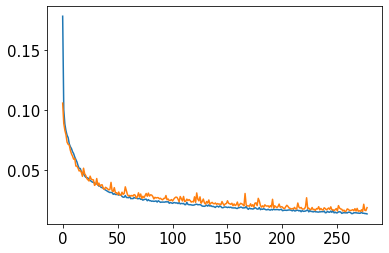

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

# Model evaluation

**on train-test**

MSE Train 0.01392380201142015
RMSE Train 0.11799916106235735
MAE Train 0.08489184716848061
MAPE Train 1.2715614746513544
R Train 0.9930939631370619
MSE Test 0.014967394813847958
RMSE Test 0.12234130461069948
MAE Test 0.08933988263076155
MAPE Test 0.9187590413447699
R Test 0.9924501749458273


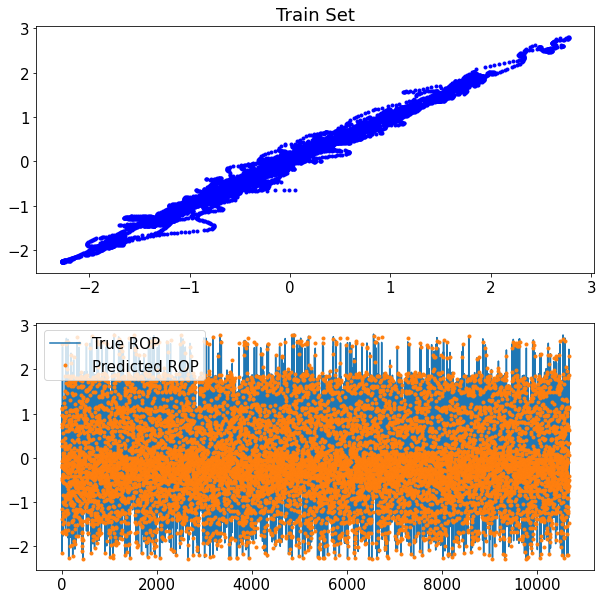

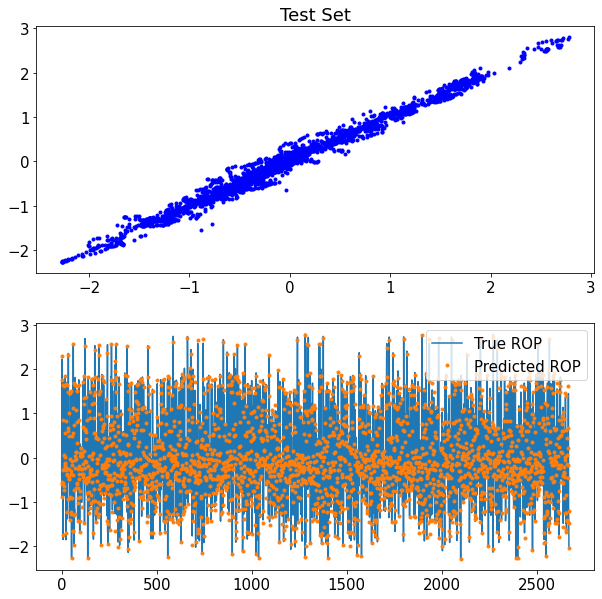

In [ ]:
# train
ytr_pred = model.predict(xtr).reshape(-1,1)
mse_tr = MSE(ytr_pred,ytr.reshape(-1,1))
rmse_tr = mse_tr**0.5
r2_tr = R2(ytr_pred,ytr.reshape(-1,1))
mae_tr = MAE(ytr.reshape(-1,1),ytr_pred)
mape_tr = MAPE(ytr.reshape(-1,1),ytr_pred)
print('MSE Train',mse_tr)
print('RMSE Train',rmse_tr)
print('MAE Train',mae_tr)
print('MAPE Train',mape_tr)
print('R Train',r2_tr)
font = {'size'   : 15}
matplotlib.rc('font', **font)
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.title('Train Set')
plt.plot(ytr_pred,ytr.reshape(-1,1),'.b')
plt.subplot(212)
plt.plot(ytr.reshape(-1,1),label='True ROP')
plt.plot(ytr_pred,'.',label='Predicted ROP')
plt.legend()

# test
yts_pred = model.predict(xts).reshape(-1,1)
mse_ts = MSE(yts_pred,yts.reshape(-1,1))
rmse_ts = mse_ts**0.5
r2_ts = R2(yts_pred,yts.reshape(-1,1))
mae_ts = MAE(yts.reshape(-1,1),yts_pred)
mape_ts = MAPE(yts.reshape(-1,1),yts_pred)
print('MSE Test',mse_ts)
print('RMSE Test',rmse_ts)
print('MAE Test',mae_ts)
print('MAPE Test',mape_ts)
print('R Test',r2_ts)
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.title('Test Set')
plt.plot(yts_pred,yts.reshape(-1,1),'.b')
plt.subplot(212)
plt.plot(yts.reshape(-1,1),label='True ROP')
plt.plot(yts_pred,'.',label='Predicted ROP')
plt.legend()

# BINGHAM Model evaluation

MSE Train 0.02849675614547131
RMSE Train 0.16880982241999815
MAE Train 0.13482946455218195
MAPE Train 0.5678681306417255
R Train 0.7770365613441557
MSE Test 0.027922828144463233
RMSE Test 0.16710125117563673
MAE Test 0.1324721145864621
MAPE Test 0.5614182591429837
R Test 0.782182973342964


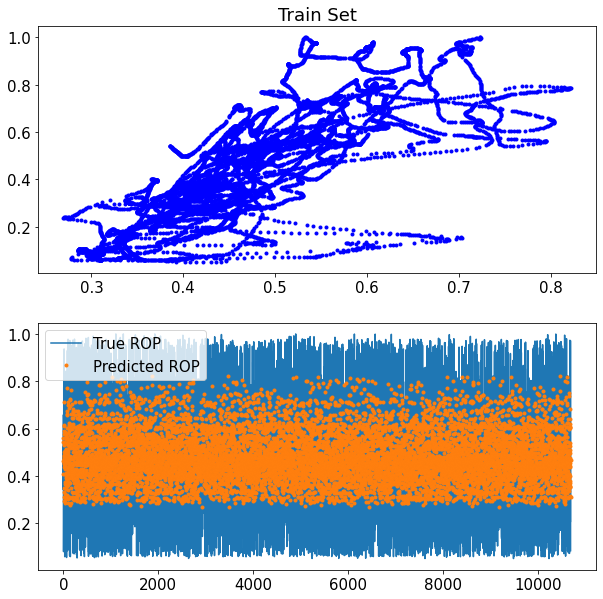

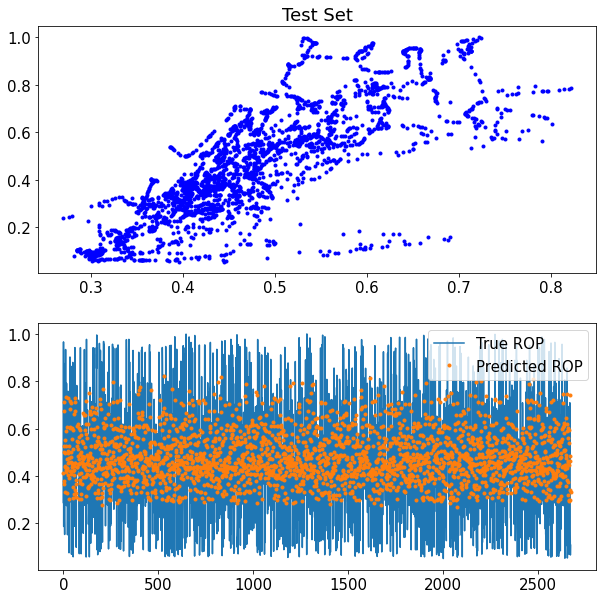

In [ ]:
# train
Bing_ytr_pred = bing_model.predict(Bing_xtr).reshape(-1,1)
mse_tr = MSE(Bing_ytr_pred,Bing_ytr.reshape(-1,1))
rmse_tr = mse_tr**0.5
r2_tr = R2(Bing_ytr_pred,Bing_ytr.reshape(-1,1))
mae_tr = MAE(Bing_ytr.reshape(-1,1),Bing_ytr_pred)
mape_tr = MAPE(Bing_ytr.reshape(-1,1),Bing_ytr_pred)
print('MSE Train',mse_tr)
print('RMSE Train',rmse_tr)
print('MAE Train',mae_tr)
print('MAPE Train',mape_tr)
print('R Train',r2_tr)
font = {'size'   : 15}
matplotlib.rc('font', **font)
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.title('Train Set')
plt.plot(Bing_ytr_pred,Bing_ytr.reshape(-1,1),'.b')
plt.subplot(212)
plt.plot(Bing_ytr.reshape(-1,1),label='True ROP')
plt.plot(Bing_ytr_pred,'.',label='Predicted ROP')
plt.legend()

# test
Bing_yts_pred = bing_model.predict(Bing_xts).reshape(-1,1)
mse_ts = MSE(Bing_yts_pred,Bing_yts.reshape(-1,1))
rmse_ts = mse_ts**0.5
r2_ts = R2(Bing_yts_pred,Bing_yts.reshape(-1,1))
mae_ts = MAE(Bing_yts.reshape(-1,1),Bing_yts_pred)
mape_ts = MAPE(Bing_yts.reshape(-1,1),Bing_yts_pred)
print('MSE Test',mse_ts)
print('RMSE Test',rmse_ts)
print('MAE Test',mae_ts)
print('MAPE Test',mape_ts)
print('R Test',r2_ts)
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.title('Test Set')
plt.plot(Bing_yts_pred,Bing_yts.reshape(-1,1),'.b')
plt.subplot(212)
plt.plot(Bing_yts.reshape(-1,1),label='True ROP')
plt.plot(Bing_yts_pred,'.',label='Predicted ROP')
plt.legend()


**on blind set**

In [ ]:
df_17 = pd.read_excel('D:\\Hassan\\Work\\my project\\paper\\rop prediction\\thesis paper\\data\\F17-cleaned_short.xlsx')
data_17 = df_17.values[:,1:]
df_17

Bing_df_17 = pd.read_excel('D:\\Hassan\\Work\\my project\\paper\\rop prediction\\thesis paper\\data\\for bingham\\F17-cleaned_divMax_short.xlsx')
Bing_data_17 = Bing_df_17.values[:,1:]
Bing_df_17

,Depth,ROP (m/hr),WOB (klb),TORQUE (klb.ft),MW (g/cc),CGR (GAPI),DT (micSec/ft)
0,2706,0.779107,0.911080,0.967376,0.956728,0.300063,0.763274
1,2707,0.778929,0.911836,0.964577,0.956728,0.300983,0.765869
2,2708,0.780043,0.912591,0.961778,0.956728,0.301904,0.768464
3,2709,0.781287,0.913346,0.958979,0.956728,0.302824,0.771060
4,2710,0.782988,0.914101,0.956180,0.956728,0.303745,0.773655
...,...,...,...,...,...,...,...
659,3365,0.378018,0.507478,0.595833,0.990836,0.228950,0.691294
660,3366,0.379631,0.493542,0.595810,0.991899,0.234700,0.691135
661,3367,0.380986,0.479607,0.595787,0.992961,0.240451,0.690975
662,3368,0.384999,0.465672,0.595765,0.994024,0.246201,0.690816


In [ ]:
Bing_data_17

array([[0.86955207, 0.91108024, 0.96737625, 0.95672766, 0.30006256,
        0.76327367],
       [0.86652858, 0.91183554, 0.96457712, 0.95672766, 0.30098305,
        0.76586899],
       [0.86350508, 0.91259084, 0.96177799, 0.95672766, 0.30190353,
        0.76846431],
       ...,
       [0.10475658, 0.47960721, 0.5957875 , 0.99296144, 0.24045051,
        0.6909754 ],
       [0.10404441, 0.46567196, 0.59576464, 0.99402393, 0.24620053,
        0.69081589],
       [0.10333223, 0.45173672, 0.59574179, 0.99508643, 0.25195055,
        0.69065639]])

In [ ]:
x_blind = data_17[:,1:]
y_blind = data_17[:,0]

Bing_x_blind = Bing_data_17[:,[1,2]]
Bing_y_blind = Bing_data_17[:,0]

In [ ]:
x_blind = x_blind.reshape(x_blind.shape + (1,))

Bing_x_blind.shape

(664, 2)

MSE Blind: 0.748129535929973
RMSE Blind: 0.12234130461069948
MAE Blind 0.669725430941827
MAPE Blind 5.740952218275569
R Blind: 0.5864612247342594


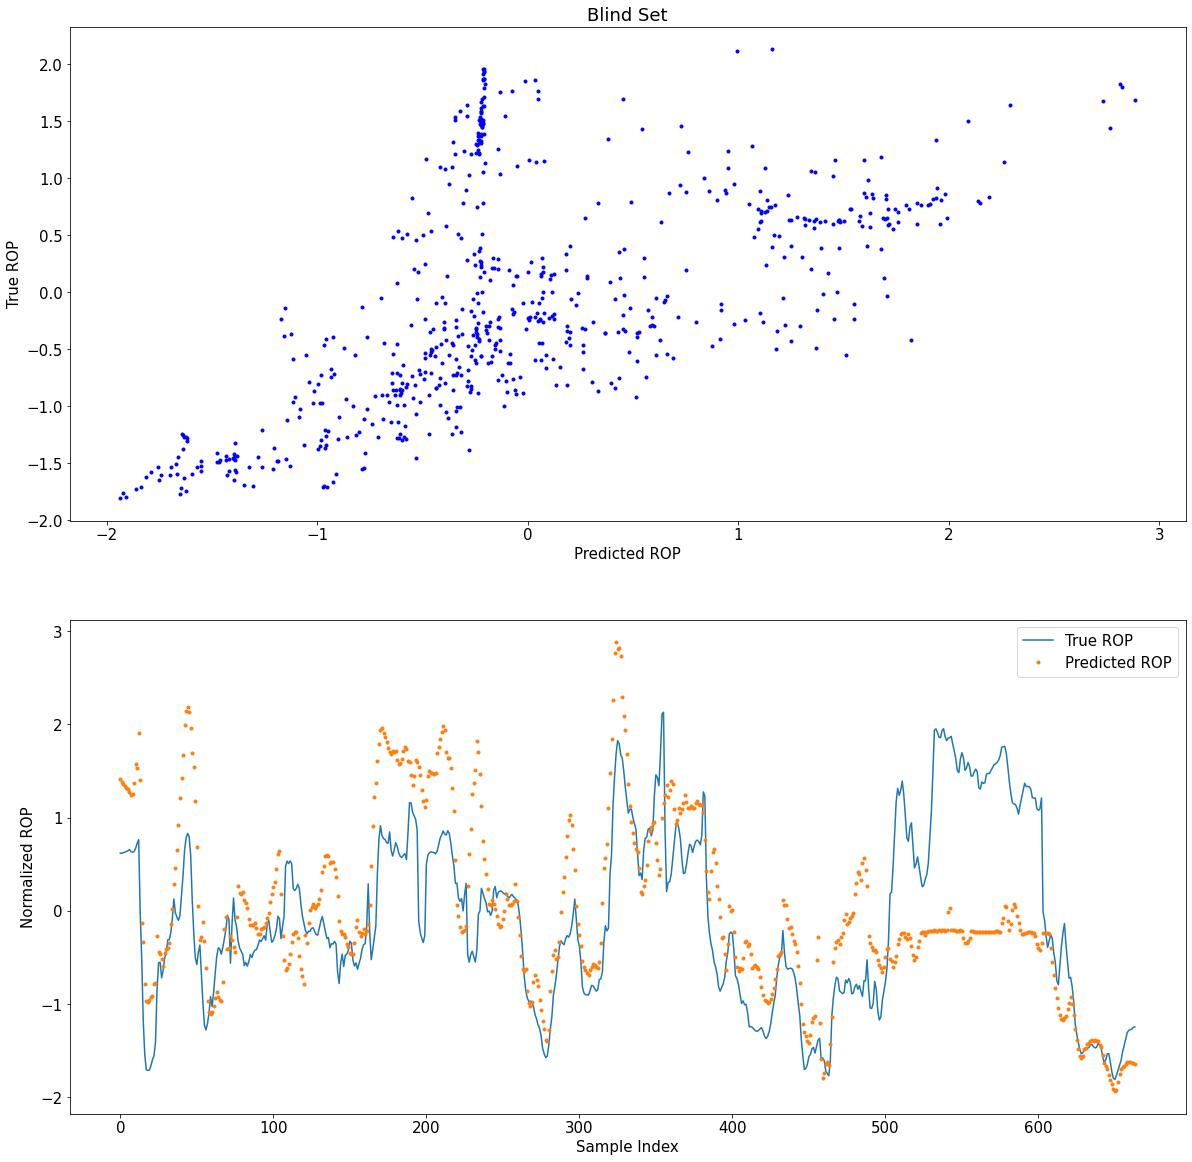

In [ ]:
# without bingham
y_blind_pred = model.predict(x_blind).reshape(-1,1)
mse_b = MSE(y_blind_pred,y_blind.reshape(-1,1))
rmse_b = mse_ts**0.5
r2_b = R2(y_blind_pred,y_blind.reshape(-1,1))
mae_b = MAE(y_blind.reshape(-1,1),y_blind_pred)
mape_b = MAPE(y_blind.reshape(-1,1),y_blind_pred)
print('MSE Blind:',mse_b)
print('RMSE Blind:',rmse_b)
print('MAE Blind',mae_b)
print('MAPE Blind',mape_b)
print('R Blind:',r2_b)
plt.figure(figsize=(20,20))
plt.subplot(211)
plt.title('Blind Set')
plt.plot(y_blind_pred,y_blind.reshape(-1,1),'.b')
plt.xlabel('Predicted ROP')
plt.ylabel('True ROP')
plt.subplot(212)
plt.plot(y_blind.reshape(-1,1),label='True ROP')
plt.plot(y_blind_pred,'.',label='Predicted ROP')
plt.xlabel('Sample Index')
plt.ylabel('Normalized ROP')
plt.legend()


MSE Blind: 0.0586311729785422
RMSE Blind: 0.030974627226072086
MAE Blind 0.2154440151544251
MAPE Blind 0.4064241490735052
R Blind: 0.5619812657454638


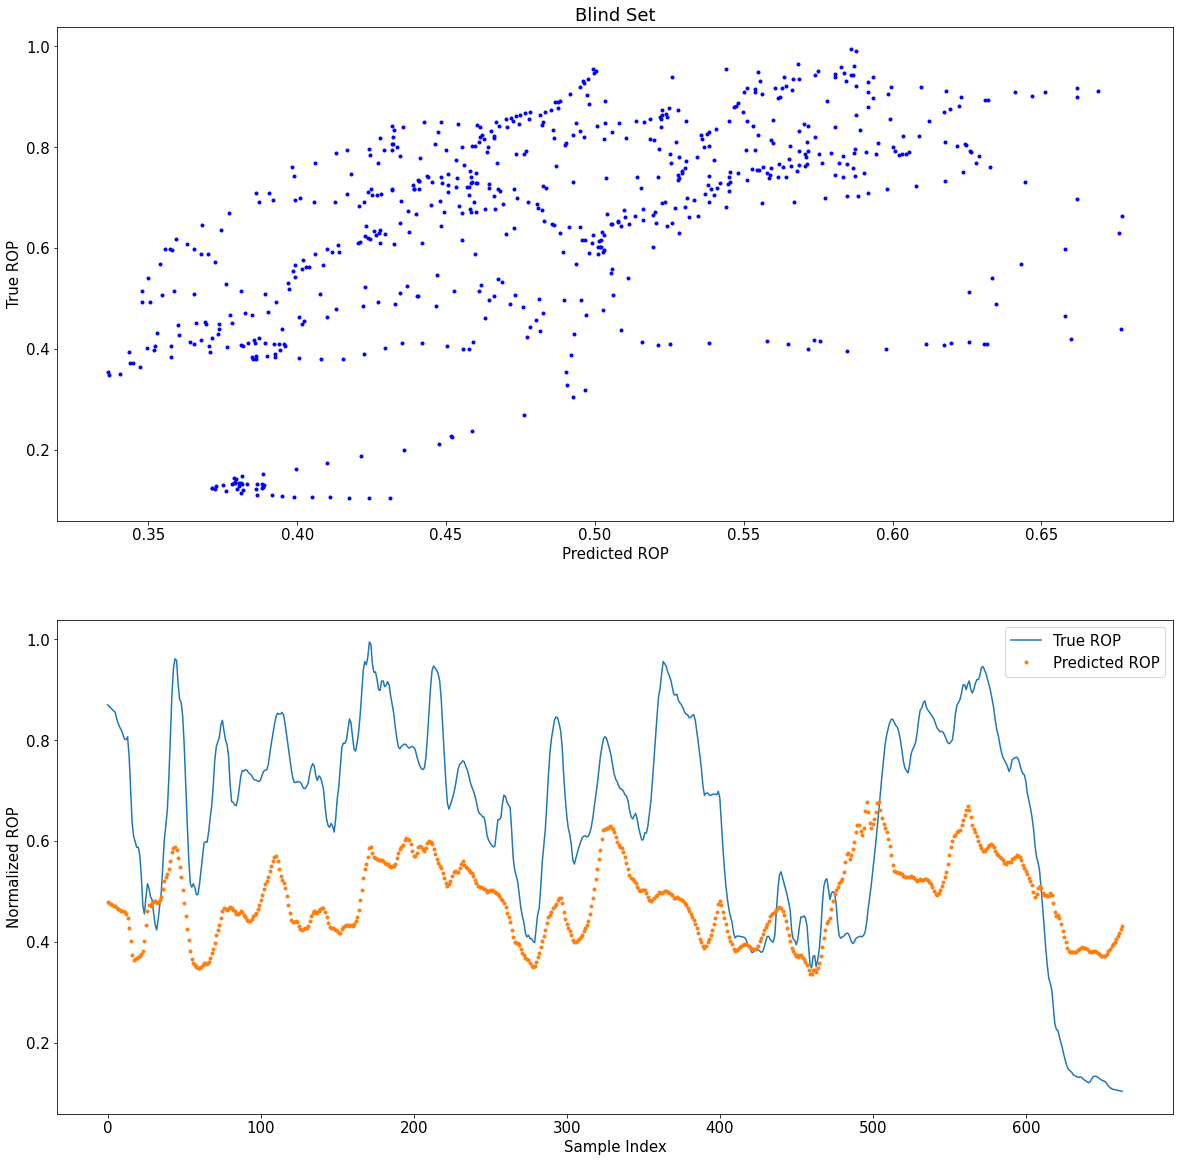

In [ ]:
# bingham
Bing_y_blind_pred = bing_model.predict(Bing_x_blind).reshape(-1,1)
mse_b = MSE(Bing_y_blind_pred,Bing_y_blind.reshape(-1,1))
rmse_b = mse_ts**0.5
r2_b = R2(Bing_y_blind_pred,Bing_y_blind.reshape(-1,1))
mae_b = MAE(Bing_y_blind.reshape(-1,1),Bing_y_blind_pred)
mape_b = MAPE(Bing_y_blind.reshape(-1,1),Bing_y_blind_pred)
print('MSE Blind:',mse_b)
print('RMSE Blind:',rmse_b)
print('MAE Blind',mae_b)
print('MAPE Blind',mape_b)
print('R Blind:',r2_b)
plt.figure(figsize=(20,20))
plt.subplot(211)
plt.title('Blind Set')
plt.plot(Bing_y_blind_pred,Bing_y_blind.reshape(-1,1),'.b')
plt.xlabel('Predicted ROP')
plt.ylabel('True ROP')
plt.subplot(212)
plt.plot(Bing_y_blind.reshape(-1,1),label='True ROP')
plt.plot(Bing_y_blind_pred,'.',label='Predicted ROP')
plt.xlabel('Sample Index')
plt.ylabel('Normalized ROP')
plt.legend()


## GAN-boosted RES 1D-CNN With Bingham model prediction as additional feature

In [ ]:
rop_bingham_data_14 = bing_model.predict(Bing_data_14[:,[2,3]])*18.094207920792
rop_bingham_data_15 = bing_model.predict(Bing_data_15[:,[2,3]])*20.6061089841584
rop_bingham_data = np.r_[rop_bingham_data_14,rop_bingham_data_15]
rop_bingham_data.shape

(13352, 1)

In [ ]:
df_data['Bingham ROP'] = (rop_bingham_data-rop_bingham_data.mean())/rop_bingham_data.std()
df_data

,ROP (m/hr),WOB (klb),TORQUE (klb.ft),MW (g/cc),CGR (GAPI),DT (micSec/ft),Bingham ROP
0,-0.066181,0.821587,-0.810115,-2.562766,-0.529477,-0.810273,-0.353358
1,-0.070161,0.822381,-0.804747,-2.562766,-0.516730,-0.808406,-0.356475
2,-0.074141,0.823176,-0.799378,-2.562766,-0.503984,-0.806539,-0.359588
3,-0.078120,0.823970,-0.794010,-2.562766,-0.491237,-0.804672,-0.362699
4,-0.082100,0.824764,-0.788642,-2.562766,-0.478490,-0.802804,-0.365805
...,...,...,...,...,...,...,...
13347,-1.336326,1.722336,-0.672164,-0.330486,-2.048028,-1.869136,0.902057
13348,-1.337903,1.723021,-0.665587,-0.316596,-2.052954,-1.872194,0.898727
13349,-1.339480,1.723706,-0.659010,-0.302705,-2.057879,-1.875252,0.895408
13350,-1.341057,1.724390,-0.652432,-0.288815,-2.062804,-1.878311,0.892095


In [ ]:
X = df_data.values[:,1:]
Y = df_data.values[:,0]
Xtr,Xts,Ytr,Yts = tts(X,Y,train_size=0.8,random_state=1,shuffle=True)
Xtr = Xtr.reshape(Xtr.shape + (1,))
Xts = Xts.reshape(Xts.shape + (1,))

print('xtr shape:',Xtr.shape)
print('xts shape:',Xts.shape)
print('ytr shape:',Ytr.shape)
print('yts shape:',Yts.shape)

xtr shape: (10681, 6, 1)
xts shape: (2671, 6, 1)
ytr shape: (10681,)
yts shape: (2671,)


In [ ]:
# 1D-Res-CNN
inputs = Input(shape= Xtr.shape[1:])
#########################
c1 = Conv1D(8,8,padding='same', activation = LeakyReLU(alpha=0.01))(inputs)
c2 = Conv1D(8,4,padding='same', activation = LeakyReLU(alpha=0.01))(c1)
c3 = Conv1D(8,8,padding='same', activation = LeakyReLU(alpha=0.01))(c2)
########################
conc = concatenate([c3,inputs])
fltn = Flatten()(conc)
dns = Dense(zdim, activation = LeakyReLU(alpha=0.01))(fltn)
out = Dense(1)(dns)
#######################coupling with pretrained generator
model = Model(inputs,out)

In [ ]:
lr = 0.002
model.compile(loss='mean_squared_error',optimizer=Adam(learning_rate=lr),metrics=['mse','mae'])
hist = model.fit(Xtr,Ytr,
                 epochs=2000,validation_split=0.3,verbose=1,
                 callbacks = [ES(monitor='val_loss', patience=50,
                                 restore_best_weights=True)])

Epoch 1/2000
234/234 [==============================] - 1s 5ms/step - loss: 0.1486 - mse: 0.1486 - mae: 0.2844 - val_loss: 0.0753 - val_mse: 0.0753 - val_mae: 0.2061
Epoch 2/2000
234/234 [==============================] - 1s 3ms/step - loss: 0.0545 - mse: 0.0545 - mae: 0.1746 - val_loss: 0.0425 - val_mse: 0.0425 - val_mae: 0.1511
Epoch 3/2000
234/234 [==============================] - 1s 3ms/step - loss: 0.0419 - mse: 0.0419 - mae: 0.1505 - val_loss: 0.0374 - val_mse: 0.0374 - val_mae: 0.1467
Epoch 4/2000
234/234 [==============================] - 1s 3ms/step - loss: 0.0359 - mse: 0.0359 - mae: 0.1385 - val_loss: 0.0311 - val_mse: 0.0311 - val_mae: 0.1289
Epoch 5/2000
234/234 [==============================] - 1s 3ms/step - loss: 0.0295 - mse: 0.0295 - mae: 0.1244 - val_loss: 0.0303 - val_mse: 0.0303 - val_mae: 0.1345
Epoch 6/2000
234/234 [==============================] - 1s 4ms/step - loss: 0.0266 - mse: 0.0266 - mae: 0.1191 - val_loss: 0.0218 - val_mse: 0.0218 - val_mae: 0.1067
Epoc

234/234 [==============================] - 1s 3ms/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0388 - val_loss: 0.0021 - val_mse: 0.0021 - val_mae: 0.0359
Epoch 100/2000
234/234 [==============================] - 1s 3ms/step - loss: 0.0021 - mse: 0.0021 - mae: 0.0347 - val_loss: 0.0029 - val_mse: 0.0029 - val_mae: 0.0417
Epoch 101/2000
234/234 [==============================] - 1s 3ms/step - loss: 0.0021 - mse: 0.0021 - mae: 0.0349 - val_loss: 0.0026 - val_mse: 0.0026 - val_mae: 0.0399
Epoch 102/2000
234/234 [==============================] - 1s 3ms/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0359 - val_loss: 0.0023 - val_mse: 0.0023 - val_mae: 0.0358
Epoch 103/2000
234/234 [==============================] - 1s 3ms/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0358 - val_loss: 0.0023 - val_mse: 0.0023 - val_mae: 0.0366
Epoch 104/2000
234/234 [==============================] - 1s 3ms/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0361 - val_loss: 0.0035 - val_mse: 0.0035 - val_mae: 0.0452
Epoch 1

Epoch 148/2000
234/234 [==============================] - 1s 3ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0283 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.0308
Epoch 149/2000
234/234 [==============================] - 1s 3ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0301 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.0316
Epoch 150/2000
234/234 [==============================] - 1s 3ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0298 - val_loss: 0.0027 - val_mse: 0.0027 - val_mae: 0.0393
Epoch 151/2000
234/234 [==============================] - 1s 3ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0325 - val_loss: 0.0016 - val_mse: 0.0016 - val_mae: 0.0306
Epoch 152/2000
234/234 [==============================] - 1s 3ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0309 - val_loss: 0.0023 - val_mse: 0.0023 - val_mae: 0.0352
Epoch 153/2000
234/234 [==============================] - 1s 3ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0303 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae:

Epoch 197/2000
234/234 [==============================] - 1s 4ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0281 - val_loss: 0.0019 - val_mse: 0.0019 - val_mae: 0.0326
Epoch 198/2000
234/234 [==============================] - 1s 4ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0284 - val_loss: 0.0016 - val_mse: 0.0016 - val_mae: 0.0302
Epoch 199/2000
234/234 [==============================] - 1s 3ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0274 - val_loss: 0.0018 - val_mse: 0.0018 - val_mae: 0.0320
Epoch 200/2000
234/234 [==============================] - 1s 3ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0320 - val_loss: 0.0018 - val_mse: 0.0018 - val_mae: 0.0323
Epoch 201/2000
234/234 [==============================] - 1s 3ms/step - loss: 0.0021 - mse: 0.0021 - mae: 0.0347 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.0328
Epoch 202/2000
234/234 [==============================] - 1s 3ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0300 - val_loss: 0.0019 - val_mse: 0.0019 - val_mae:

Epoch 246/2000
234/234 [==============================] - 1s 3ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0287 - val_loss: 0.0013 - val_mse: 0.0013 - val_mae: 0.0269
Epoch 247/2000
234/234 [==============================] - 1s 3ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0278 - val_loss: 0.0014 - val_mse: 0.0014 - val_mae: 0.0276
Epoch 248/2000
234/234 [==============================] - 1s 3ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0245 - val_loss: 0.0014 - val_mse: 0.0014 - val_mae: 0.0274
Epoch 249/2000
234/234 [==============================] - 1s 3ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0271 - val_loss: 0.0027 - val_mse: 0.0027 - val_mae: 0.0381
Epoch 250/2000
234/234 [==============================] - 1s 3ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0279 - val_loss: 0.0013 - val_mse: 0.0013 - val_mae: 0.0267
Epoch 251/2000
234/234 [==============================] - 1s 3ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0278 - val_loss: 0.0013 - val_mse: 0.0013 - val_mae:

MSE Train 0.0008583604777651812
RMSE Train 0.029297789639581708
MAE Train 0.022737883335343795
MAPE Train 0.31829404493547897
R Train 0.9996020797716594
MSE Test 0.0009594275317941262
RMSE Test 0.030974627226072086
MAE Test 0.02395695375677193
MAPE Test 0.21923302632457956
R Test 0.9995384111296611


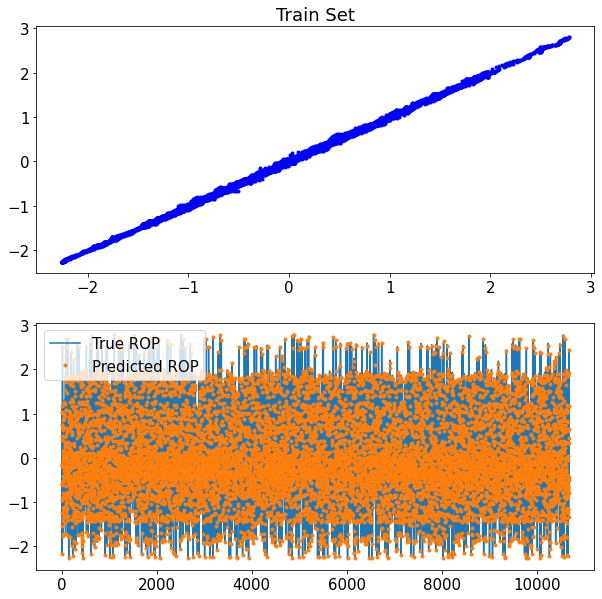

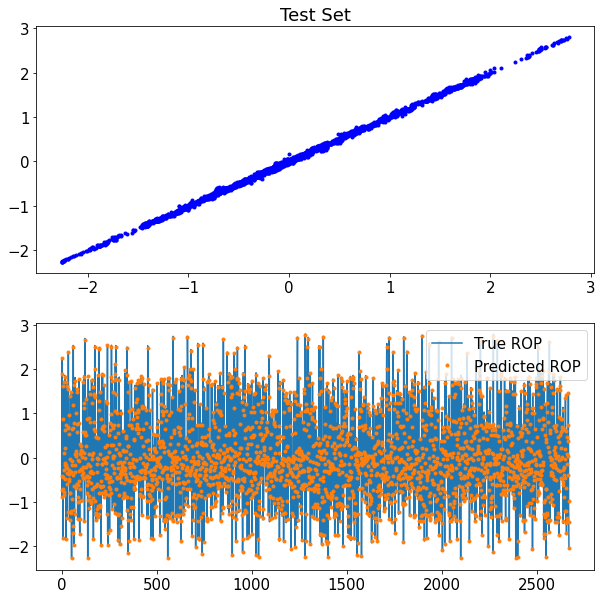

In [ ]:
# train
Ytr_pred = model.predict(Xtr).reshape(-1,1)
mse_tr = MSE(Ytr_pred,Ytr.reshape(-1,1))
rmse_tr = mse_tr**0.5
r2_tr = R2(Ytr_pred,Ytr.reshape(-1,1))
mae_tr = MAE(Ytr.reshape(-1,1),Ytr_pred)
mape_tr = MAPE(Ytr.reshape(-1,1),Ytr_pred)
print('MSE Train',mse_tr)
print('RMSE Train',rmse_tr)
print('MAE Train',mae_tr)
print('MAPE Train',mape_tr)
print('R Train',r2_tr)
font = {'size'   : 15}
matplotlib.rc('font', **font)
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.title('Train Set')
plt.plot(Ytr_pred,Ytr.reshape(-1,1),'.b')
plt.subplot(212)
plt.plot(Ytr.reshape(-1,1),label='True ROP')
plt.plot(Ytr_pred,'.',label='Predicted ROP')
plt.legend()

# test
Yts_pred = model.predict(Xts).reshape(-1,1)
mse_ts = MSE(Yts_pred,Yts.reshape(-1,1))
rmse_ts = mse_ts**0.5
r2_ts = R2(Yts_pred,Yts.reshape(-1,1))
mae_ts = MAE(Yts.reshape(-1,1),Yts_pred)
mape_ts = MAPE(Yts.reshape(-1,1),Yts_pred)
print('MSE Test',mse_ts)
print('RMSE Test',rmse_ts)
print('MAE Test',mae_ts)
print('MAPE Test',mape_ts)
print('R Test',r2_ts)
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.title('Test Set')
plt.plot(Yts_pred,Yts.reshape(-1,1),'.b')
plt.subplot(212)
plt.plot(Yts.reshape(-1,1),label='True ROP')
plt.plot(Yts_pred,'.',label='Predicted ROP')
plt.legend()

In [ ]:
df_17

,Depth,ROP (m/hr),WOB (klb),TORQUE (klb.ft),MW (g/cc),CGR (GAPI),DT (micSec/ft),Bingham ROP
0,2706,0.619855,1.329010,1.639735,-2.244245,0.483576,-0.908901,-0.092127
1,2707,0.619010,1.333432,1.608809,-2.244245,0.490153,-0.877742,-0.112376
2,2708,0.624295,1.337854,1.577882,-2.244245,0.496730,-0.846582,-0.132606
3,2709,0.630194,1.342276,1.546956,-2.244245,0.503307,-0.815423,-0.152816
4,2710,0.638257,1.346698,1.516029,-2.244245,0.509884,-0.784263,-0.173008
...,...,...,...,...,...,...,...,...
659,3365,-1.281980,-1.033979,-2.465313,2.357350,-0.024514,-1.773085,-1.019922
660,3366,-1.274330,-1.115566,-2.465565,2.500691,0.016569,-1.775000,-0.941828
661,3367,-1.267907,-1.197153,-2.465818,2.644031,0.057653,-1.776915,-0.860251
662,3368,-1.248878,-1.278740,-2.466070,2.787372,0.098736,-1.778830,-0.774927


In [ ]:
X_blind = df_17.values[:,2:]
X_blind = X_blind.reshape(X_blind.shape + (1,))
print(X_blind.shape)
Y_blind = df_17.values[:,1].reshape(-1,1)

(664, 6, 1)


MSE Train 0.4626153821454985
RMSE Train 0.680158350787152
MAE Train 0.4986094310296754
MAPE Train 2.6693944055082555
R Train 0.7498564875409626


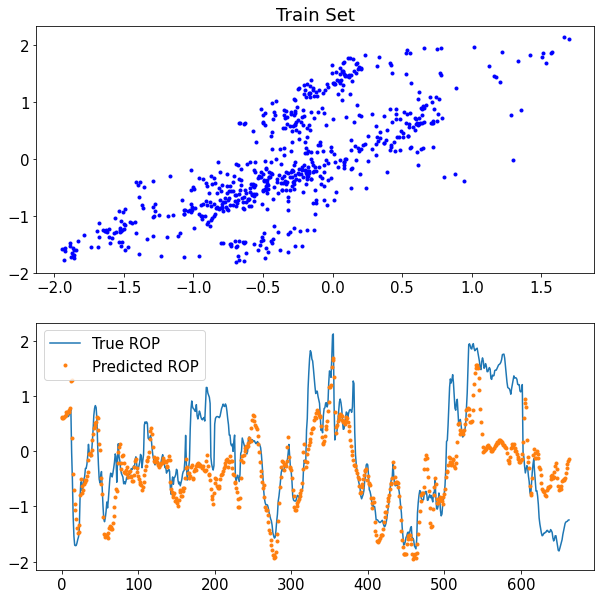

In [ ]:
# train
Yb_pred = model.predict(X_blind).reshape(-1,1)
mse_tr = MSE(Y_blind,Yb_pred.reshape(-1,1))
rmse_tr = mse_tr**0.5
r2_tr = R2(Yb_pred,Y_blind.reshape(-1,1))
mae_tr = MAE(Y_blind.reshape(-1,1),Yb_pred)
mape_tr = MAPE(Y_blind.reshape(-1,1),Yb_pred)
print('MSE Train',mse_tr)
print('RMSE Train',rmse_tr)
print('MAE Train',mae_tr)
print('MAPE Train',mape_tr)
print('R Train',r2_tr)
font = {'size'   : 15}
matplotlib.rc('font', **font)
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.title('Train Set')
plt.plot(Yb_pred,Y_blind.reshape(-1,1),'.b')
plt.subplot(212)
plt.plot(Y_blind.reshape(-1,1),label='True ROP')
plt.plot(Yb_pred,'.',label='Predicted ROP')
plt.legend()

# Model Saving

In [ ]:
address = 'D:\\Hassan\\Work\\my project\\paper\\rop prediction\\thesis paper\\models\\NEW_GB-MLP.tf'
model.save(address)
address = 'D:\\Hassan\\Work\\my project\\paper\\rop prediction\\thesis paper\\models\\NEW_GB-MLP.h5'
model.save(address)

INFO:tensorflow:Assets written to: D:\Hassan\Work\my project\paper\rop prediction\thesis paper\models\NEW_GB-MLP.tf\assets


In [ ]:
address = 'D:\\Hassan\\Work\\my project\\paper\\rop prediction\\thesis paper\\models\\bingham.tf'
bing_model.save(address)
address = 'D:\\Hassan\\Work\\my project\\paper\\rop prediction\\thesis paper\\models\\bingham.h5'
#bing_model.save(address)

INFO:tensorflow:Assets written to: D:\Hassan\Work\my project\paper\rop prediction\thesis paper\models\bingham.tf\assets
